In [131]:
import pandas as pd
import glob
import json
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style="whitegrid")

# Configure Matplotlib to use LaTeX for rendering
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{times}",
    })

In [132]:
def extract_name(model):
    if 'EleutherAI' in model:
        return 'Base'
    elif 'sft' in model:
        return 'SFT'
    elif 'roberta' in model:
        return 'RLHF'
    elif 'irl' in model:    
        return 'IRL RLHF'
    else:
        return model

In [179]:
def get_results(files):
    df = pd.DataFrame()
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
        results_data = data['results']
        temp_df = pd.json_normalize(results_data)
        temp_df.insert(loc=0, column='model', value=file.split('/')[-2])
        df = pd.concat([df, temp_df], ignore_index=True)
    df = df.drop(columns=[col for col in df.columns if 'alias' in col])
    df.columns = [col.replace(',none', '') for col in df.columns]
    df = df.filter(regex='model|\.acc(?!\w)|\.acc_stderr')
    df.columns = [col.replace('.acc', '_acc') for col in df.columns]
    df.columns = [col.replace('.acc_stderr', 'acc_stderr') for col in df.columns]
    # sort by fine-tuning stage
    df['method'] = df['model'].map(lambda x: extract_name(x))
    df['method'] = pd.Categorical(df['method'], categories=['Base', 'SFT', 'RLHF', 'IRL RLHF'], ordered=True)
    # add model size
    df['model_size'] = df['model'].map(lambda x: re.search(r'(pythia-|pythia)(\w+)', x).group(2))
    df['model_size'] = df['model_size'].map(lambda x: "Pythia-" + x.title())
    df = df.sort_values('method')
    return df

In [180]:
files = glob.glob('results/lm-eval/70m/to_analyse/*/*/*.json')
df_70m = get_results(files)
df_70m

,model,arc_challenge_acc,arc_challenge_acc_stderr,arc_easy_acc,arc_easy_acc_stderr,boolq_acc,boolq_acc_stderr,hellaswag_acc,hellaswag_acc_stderr,lambada_openai_acc,...,openbookqa_acc,openbookqa_acc_stderr,piqa_acc,piqa_acc_stderr,sciq_acc,sciq_acc_stderr,winogrande_acc,winogrande_acc_stderr,method,model_size
0,EleutherAI__pythia-70m,0.189420,0.011451,0.368687,0.009900,0.523547,0.008735,0.265385,0.004406,0.183388,...,0.120,0.014547,0.600109,0.011430,0.603,0.015480,0.513023,0.014048,Base,Pythia-70M
2,lomahony__eleuther-pythia70m-hh-sft,0.182594,0.011290,0.388047,0.009999,0.614679,0.008512,0.262000,0.004388,0.208810,...,0.130,0.015055,0.590316,0.011474,0.594,0.015537,0.526440,0.014033,SFT,Pythia-70M
1,jaredjoss__pythia-70m-roberta-lr_3e6-kl_0035-s...,0.183447,0.011310,0.349747,0.009786,0.621713,0.008482,0.264688,0.004403,0.113332,...,0.156,0.016244,0.567465,0.011559,0.531,0.015789,0.520126,0.014041,RLHF,Pythia-70M
3,jaredjoss__pythia-70m-irl-10eps-58reps-rlhf-model,0.166382,0.010883,0.336279,0.009694,0.621713,0.008482,0.263593,0.004397,0.164176,...,0.132,0.015153,0.578346,0.011522,0.560,0.015705,0.522494,0.014038,IRL RLHF,Pythia-70M


In [181]:
def plot_comparison(df, metrics, savefig=False):
    df = df.copy()
    model_size = re.search(r'(pythia-|pythia)(\w+)', df["model"].iloc[0]).group(2)
    df['model'] = df['model'].map(lambda x: extract_name(x))
    models  = df['model'].tolist()

    data = {
        'Category': metrics * len(models),
        'Group': [model for model in models for _ in range(len(metrics))],
        'Value': [df[df['model'] == model][metric].iloc[0] for model in models for metric in metrics],
        'Error': [df[df['model'] == model][f"{metric}_stderr"].iloc[0] for model in models for metric in metrics]

    }

    plot_df = pd.DataFrame(data)    
    plot_df['Group'] = pd.Categorical(plot_df['Group'], categories=['Base', 'SFT', 'RLHF', 'IRL RLHF'], ordered=True)
    plot_df['Category'] = pd.Categorical(plot_df['Category'], categories=metrics, ordered=True)

    # Remove unused categories
    plot_df['Group'] = plot_df['Group'].cat.remove_unused_categories()

    plt.figure(figsize=(14, 6))
    ax = sns.barplot(x='Category', y='Value', hue='Group', data=plot_df, palette='mako')

    # Correctly position error bars
    for i, (category, group) in enumerate(zip(plot_df['Category'], plot_df['Group'])):
        # Find the corresponding x position for each bar
        x = ax.get_xticks()[metrics.index(category)] + (list(plot_df['Group'].cat.categories).index(group) - 1.5) * 0.2
        y = plot_df[(plot_df['Category'] == category) & (plot_df['Group'] == group)]['Value'].values[0]
        err = plot_df[(plot_df['Category'] == category) & (plot_df['Group'] == group)]['Error'].values[0]
        ax.errorbar(x, y, yerr=err, fmt='none', c='black', capsize=5)

    plt.title(f'{model_size} Model - Metric Per Fine-Tuning Stage', size=16)
    plt.xlabel('Metric', size=14)
    plt.ylabel('Value', size=14)
    plt.legend()
    if savefig:
        plt.tight_layout()
        plt.savefig(f"plots/lm_eval/{model_size}_{'average' if 'average' in metrics[0] else 'metric'}_comparison.png", dpi=300)
    plt.show()

## 70m

In [182]:
files = glob.glob('results/lm-eval/70m/to_analyse/*/*/*.json')
df_70m = get_results(files)
# calculate average metric for rows where the column names contain 'acc' but no 'acc_stderr':
acc_cols = [col for col in df_70m.columns if 'acc' in col and 'acc_stderr' not in col]
err_cols = [col for col in df_70m.columns if 'acc_stderr' in col]
df_70m['acc_avg'] = df_70m[acc_cols].mean(axis=1)
df_70m['err_avg'] = df_70m[err_cols].mean(axis=1)
df_70m

,model,arc_challenge_acc,arc_challenge_acc_stderr,arc_easy_acc,arc_easy_acc_stderr,boolq_acc,boolq_acc_stderr,hellaswag_acc,hellaswag_acc_stderr,lambada_openai_acc,...,piqa_acc,piqa_acc_stderr,sciq_acc,sciq_acc_stderr,winogrande_acc,winogrande_acc_stderr,method,model_size,acc_avg,err_avg
0,EleutherAI__pythia-70m,0.189420,0.011451,0.368687,0.009900,0.523547,0.008735,0.265385,0.004406,0.183388,...,0.600109,0.011430,0.603,0.015480,0.513023,0.014048,Base,Pythia-70M,0.374062,0.010599
2,lomahony__eleuther-pythia70m-hh-sft,0.182594,0.011290,0.388047,0.009999,0.614679,0.008512,0.262000,0.004388,0.208810,...,0.590316,0.011474,0.594,0.015537,0.526440,0.014033,SFT,Pythia-70M,0.388543,0.010661
1,jaredjoss__pythia-70m-roberta-lr_3e6-kl_0035-s...,0.183447,0.011310,0.349747,0.009786,0.621713,0.008482,0.264688,0.004403,0.113332,...,0.567465,0.011559,0.531,0.015789,0.520126,0.014041,RLHF,Pythia-70M,0.367502,0.010670
3,jaredjoss__pythia-70m-irl-10eps-58reps-rlhf-model,0.166382,0.010883,0.336279,0.009694,0.621713,0.008482,0.263593,0.004397,0.164176,...,0.578346,0.011522,0.560,0.015705,0.522494,0.014038,IRL RLHF,Pythia-70M,0.371665,0.010559


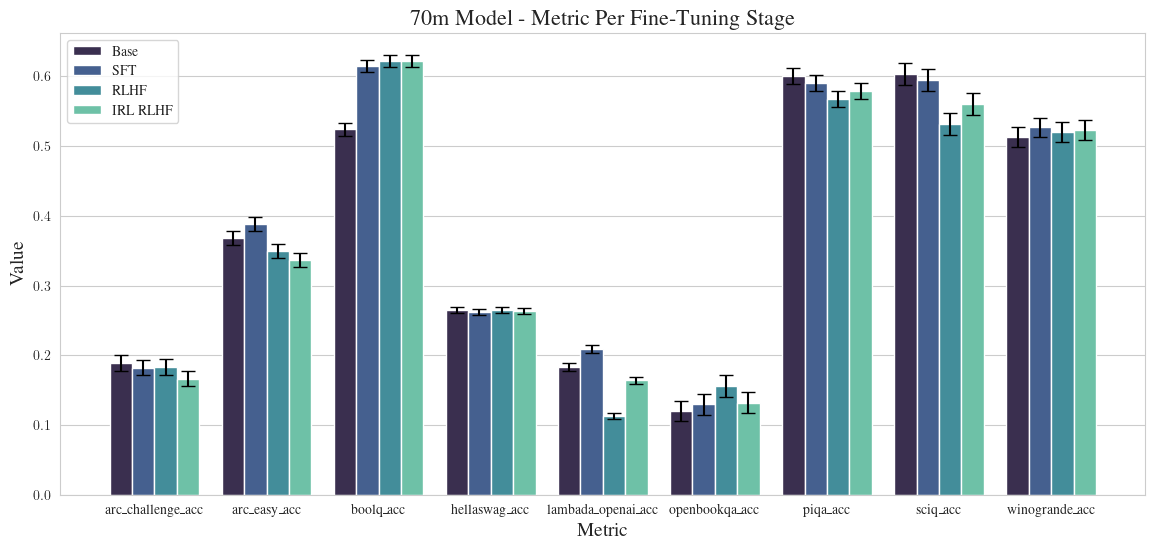

In [183]:
# plot
metrics = [col for col in df_70m.columns if '_acc' in col and '_stderr' not in col] # list(df_70m.columns)[1:len(df_70m.columns)-1]
plot_comparison(df_70m, metrics, savefig=False)

## 160m

In [184]:
files = glob.glob('results/lm-eval/160m/to_analyse/*/*/*.json')
df_160m = get_results(files)
df_160m['acc_avg'] = df_160m[acc_cols].mean(axis=1)
df_160m['err_avg'] = df_160m[err_cols].mean(axis=1)
df_160m

,model,arc_challenge_acc,arc_challenge_acc_stderr,arc_easy_acc,arc_easy_acc_stderr,boolq_acc,boolq_acc_stderr,hellaswag_acc,hellaswag_acc_stderr,lambada_openai_acc,...,piqa_acc,piqa_acc_stderr,sciq_acc,sciq_acc_stderr,winogrande_acc,winogrande_acc_stderr,method,model_size,acc_avg,err_avg
2,EleutherAI__pythia-160m,0.188567,0.011431,0.431818,0.010164,0.545260,0.008709,0.283211,0.004496,0.327770,...,0.620239,0.011323,0.738,0.013912,0.517758,0.014044,Base,Pythia-160M,0.424069,0.010799
0,lomahony__eleuther-pythia160m-hh-sft,0.194539,0.011568,0.448653,0.010206,0.614067,0.008514,0.284605,0.004503,0.340190,...,0.631121,0.011258,0.738,0.013912,0.509077,0.014050,SFT,Pythia-160M,0.437584,0.010859
1,jaredjoss__pythia-160m-roberta-lr_1e6-kl_0035-...,0.191126,0.011490,0.442340,0.010191,0.589602,0.008603,0.285600,0.004508,0.317485,...,0.622416,0.011311,0.732,0.014013,0.514601,0.014046,RLHF,Pythia-160M,0.429463,0.010829


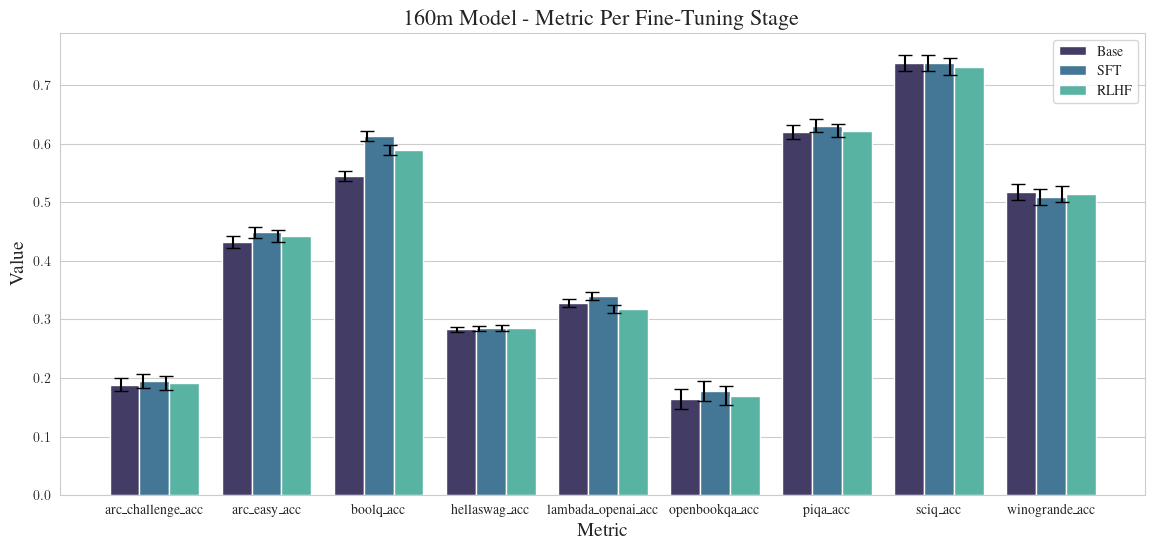

In [185]:
# plot
plot_comparison(df_160m, metrics, savefig=False)

## 410m

In [186]:
files = glob.glob('results/lm-eval/410m/to_analyse/*/*/*.json')
df_410m = get_results(files)
df_410m['acc_avg'] = df_410m[acc_cols].mean(axis=1)
df_410m['err_avg'] = df_410m[err_cols].mean(axis=1)
df_410m

,model,arc_challenge_acc,arc_challenge_acc_stderr,arc_easy_acc,arc_easy_acc_stderr,boolq_acc,boolq_acc_stderr,hellaswag_acc,hellaswag_acc_stderr,lambada_openai_acc,...,piqa_acc,piqa_acc_stderr,sciq_acc,sciq_acc_stderr,winogrande_acc,winogrande_acc_stderr,method,model_size,acc_avg,err_avg
2,EleutherAI__pythia-410m,0.214164,0.011988,0.522306,0.010250,0.608563,0.008536,0.336985,0.004717,0.515234,...,0.669206,0.010978,0.810,0.012412,0.529597,0.014028,Base,Pythia-410M,0.487562,0.010794
1,lomahony__eleuther-pythia410m-hh-sft,0.226109,0.012224,0.526094,0.010246,0.618654,0.008495,0.341665,0.004733,0.508442,...,0.680631,0.010878,0.810,0.012412,0.535912,0.014016,SFT,Pythia-410M,0.493279,0.010845
3,jaredjoss__pythia-410m-roberta-lr_8e7-kl_01-st...,0.219283,0.012091,0.523148,0.010249,0.608563,0.008536,0.341068,0.004731,0.442073,...,0.682807,0.010858,0.816,0.012259,0.529597,0.014028,RLHF,Pythia-410M,0.482949,0.010780
0,jaredjoss__pythia-410m-irl-6eps-15reps-rlhf-model,0.222696,0.012158,0.528620,0.010243,0.611621,0.008524,0.338478,0.004722,0.424801,...,0.677911,0.010902,0.816,0.012259,0.535912,0.014016,IRL RLHF,Pythia-410M,0.482004,0.010776


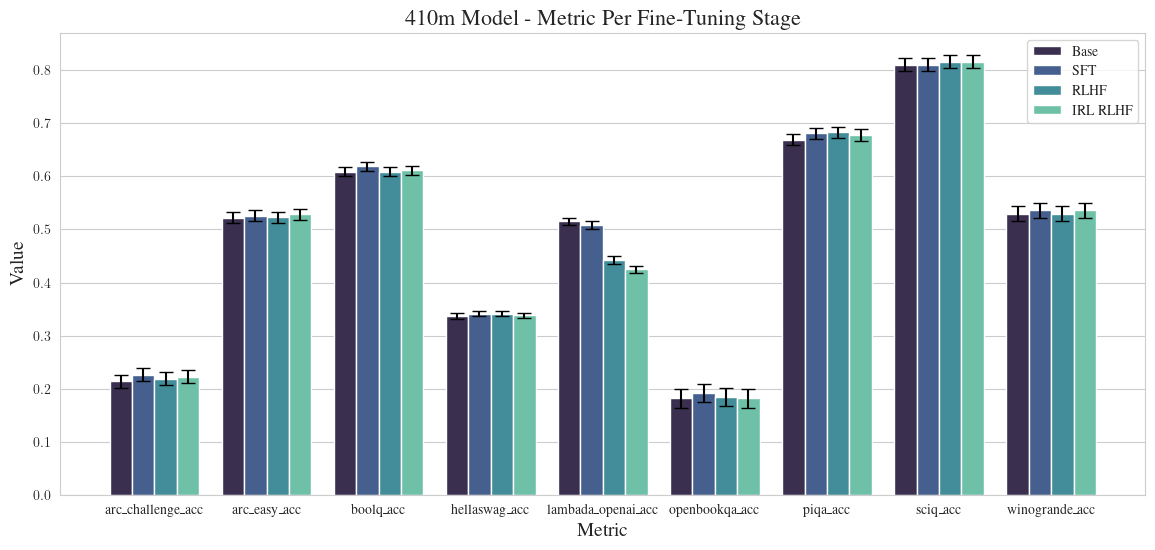

In [187]:
# plot
plot_comparison(df_410m, metrics, savefig=False)

# All

In [188]:
# combine all model results
df_combined = pd.concat([df_70m, df_410m], ignore_index=True)
average_metrics = df_combined[['model','method', 'model_size', 'acc_avg', 'err_avg']].to_dict('records')
df_combined = df_combined.drop(columns=['acc_avg', 'err_avg'])

average_metrics_df = pd.DataFrame(average_metrics)
average_metrics_df

,model,method,model_size,acc_avg,err_avg
0,EleutherAI__pythia-70m,Base,Pythia-70M,0.374062,0.010599
1,lomahony__eleuther-pythia70m-hh-sft,SFT,Pythia-70M,0.388543,0.010661
2,jaredjoss__pythia-70m-roberta-lr_3e6-kl_0035-s...,RLHF,Pythia-70M,0.367502,0.010670
3,jaredjoss__pythia-70m-irl-10eps-58reps-rlhf-model,IRL RLHF,Pythia-70M,0.371665,0.010559
4,EleutherAI__pythia-410m,Base,Pythia-410M,0.487562,0.010794
5,lomahony__eleuther-pythia410m-hh-sft,SFT,Pythia-410M,0.493279,0.010845
6,jaredjoss__pythia-410m-roberta-lr_8e7-kl_01-st...,RLHF,Pythia-410M,0.482949,0.010780
7,jaredjoss__pythia-410m-irl-6eps-15reps-rlhf-model,IRL RLHF,Pythia-410M,0.482004,0.010776


/var/folders/st/2r570j6x26l43xlczjpfdy7m0000gn/T/ipykernel_33979/1812751413.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='model_size',


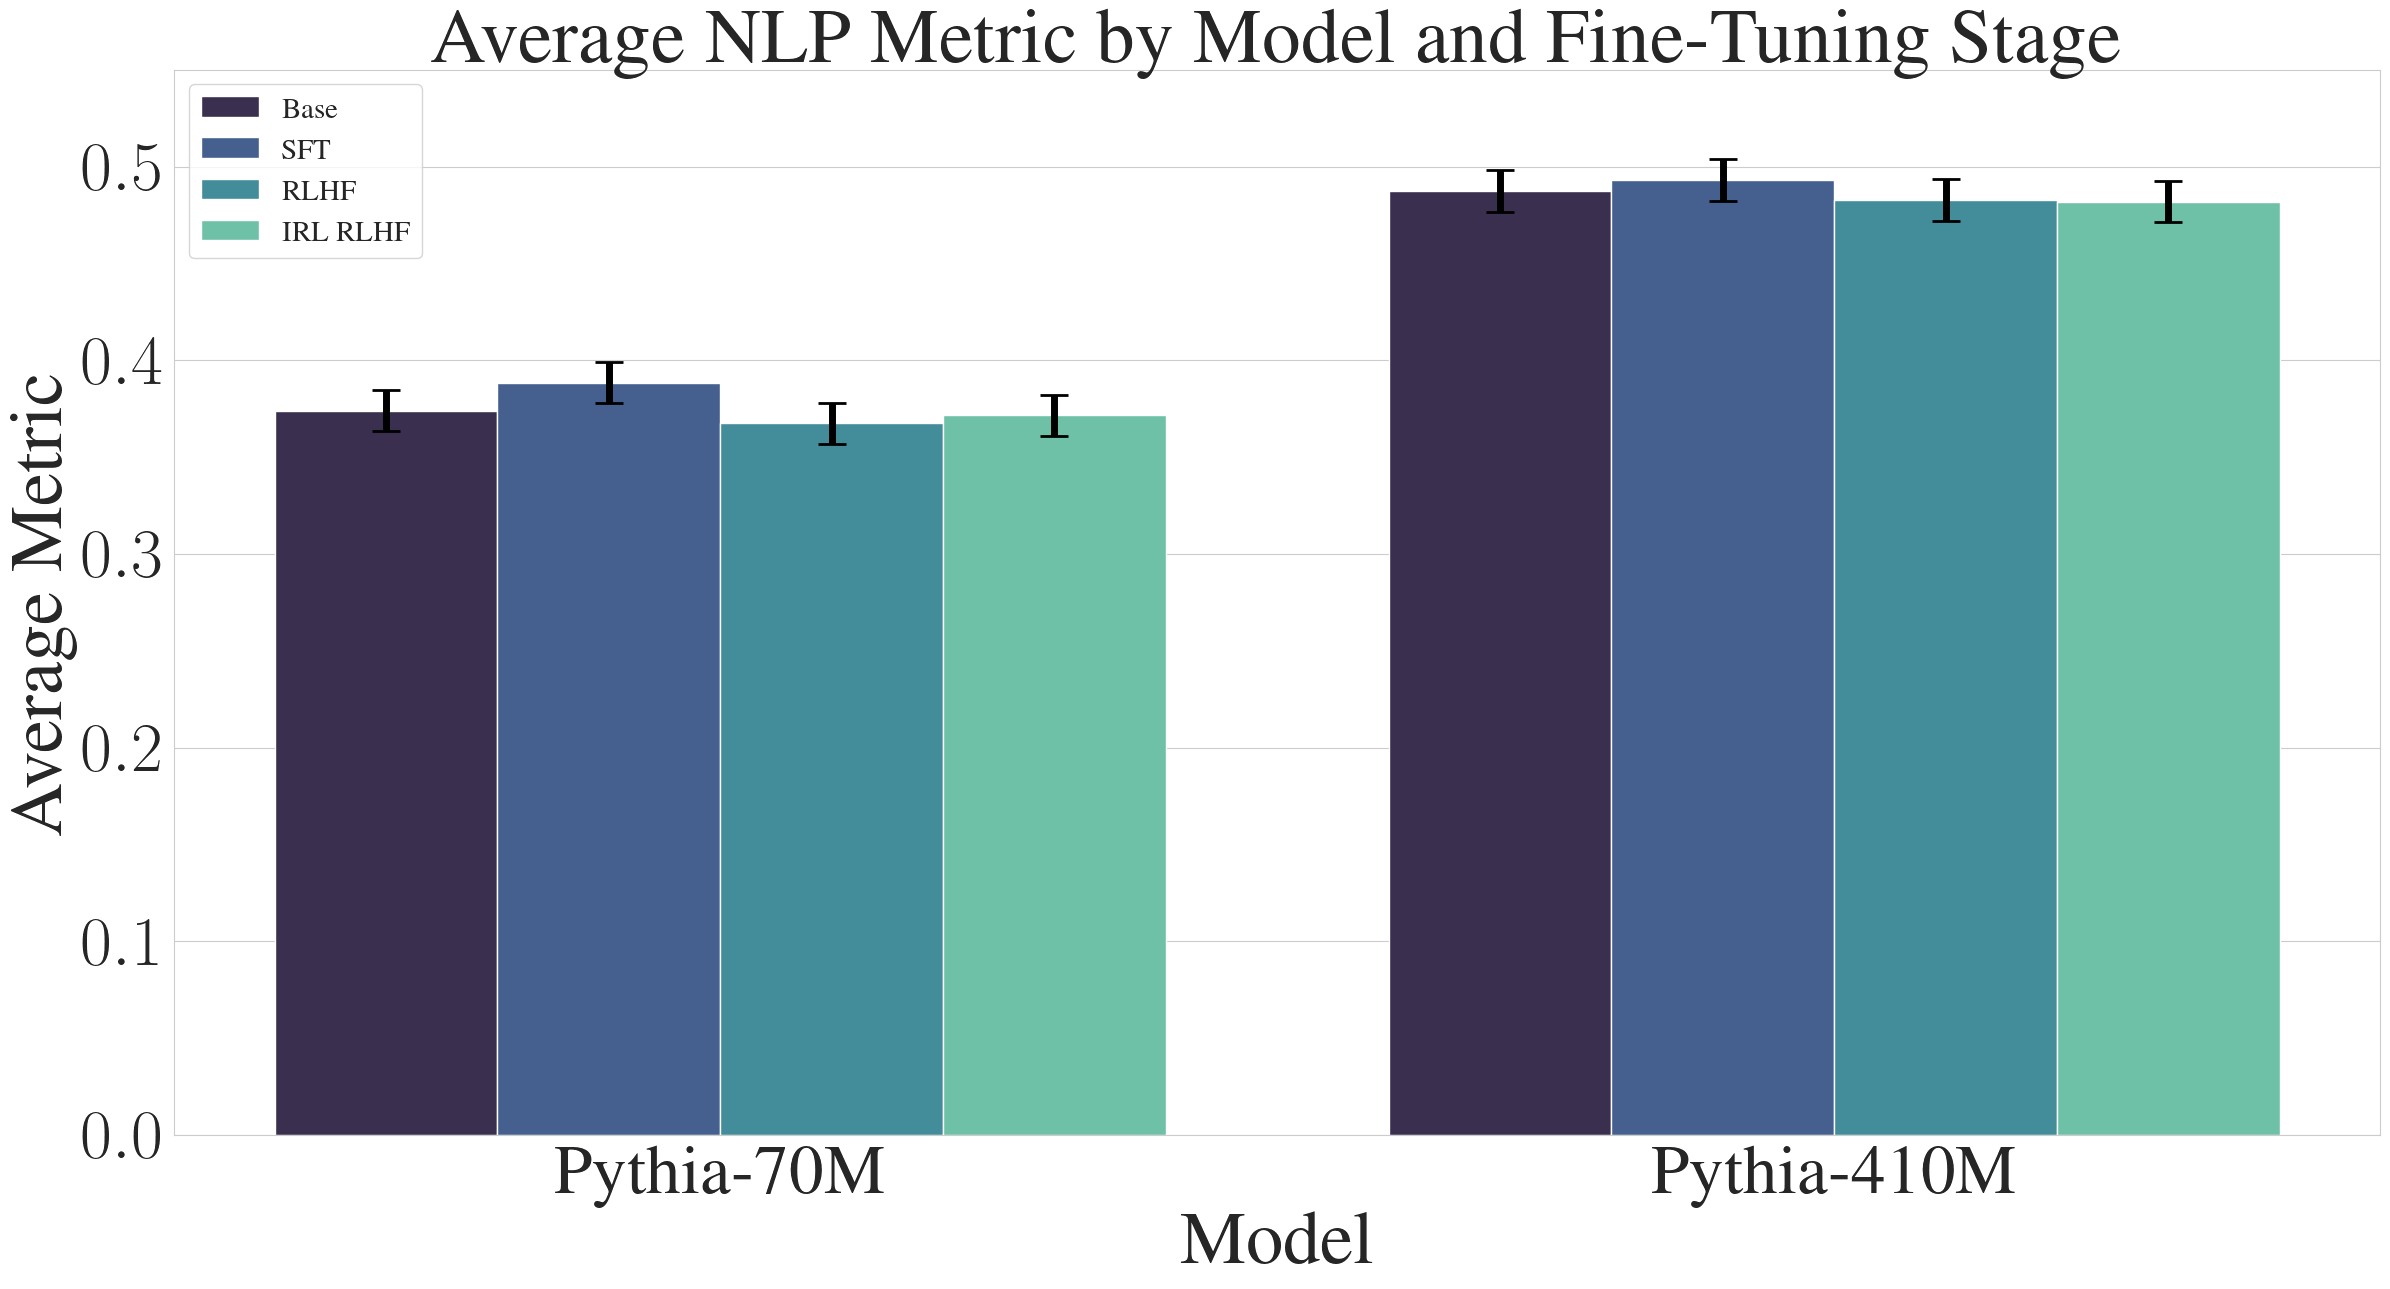

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# Creating a grouped bar chart
plt.figure(figsize=(24, 13))
ax = sns.barplot(x='model_size', 
                 y='acc_avg', 
                 hue='method', 
                 data=average_metrics_df, 
                 palette='mako', 
                 ci=None)  # Disable internal confidence interval calculations

# Manually add error bars
model_sizes = average_metrics_df['model_size'].unique()
methods = average_metrics_df['method'].unique()
for i, (model_size, method) in enumerate(zip(average_metrics_df['model_size'], average_metrics_df['method'])):
    # Find the corresponding x position for each bar
    # Calculate the bar positions dynamically
    x = ax.get_xticks()[model_sizes.tolist().index(model_size)] + (list(methods).index(method) - 1.5) * 0.2
    y = average_metrics_df[(average_metrics_df['model_size'] == model_size) & (average_metrics_df['method'] == method)]['acc_avg'].values[0]
    err = average_metrics_df[(average_metrics_df['model_size'] == model_size) & (average_metrics_df['method'] == method)]['err_avg'].values[0]
    
    # Plot error bars
    ax.errorbar(x, y, yerr=err, fmt='none', c='black', capsize=10, capthick=2, elinewidth=5)

# Adding the values to the top of the bars
# for p in ax.patches:
#     height = p.get_height()
#     if height > 0.001:  # Only annotate if the height is greater than a small threshold
#         ax.annotate(format(height, '.3f'),  # Format the value to 3 decimal places
#                     (p.get_x() + p.get_width() / 2., height),  # Set the text position
#                     ha='center', va='center',  # Center alignment
#                     size=28, xytext=(0, 10),  # Text size and offset
#                     textcoords='offset points')  # Offset the text from the point

# Setting the title and labels
plt.title('Average NLP Metric by Model and Fine-Tuning Stage', size=56)
plt.xlabel('Model', size=54)
plt.ylabel('Average Metric', size=54)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.legend(fontsize=21)
plt.ylim(0, 0.55)

plt.tight_layout()
plt.savefig(f"plots/lm_eval/average_metric_comparison.png", dpi=600, transparent=True)
plt.show()

In [45]:
def percentage_decrease(start, final):
    return ((start - final) / start) * 100

def get_ave_metric(model_size, method):
    return average_metrics_df[(average_metrics_df['model_size'] == model_size) & (average_metrics_df['method'] == method)]['average_metric'].iloc[0]

# 70m
base_sft_70m = percentage_decrease(get_ave_metric('70m', 'Base'), get_ave_metric('70m', 'SFT'))
sft_rlhf_70m = percentage_decrease(get_ave_metric('70m', 'SFT'), get_ave_metric('70m', 'RLHF'))
rlhf_irl_70m = percentage_decrease(get_ave_metric('70m', 'RLHF'), get_ave_metric('70m', 'IRL RLHF'))

# 160m
base_sft_160m = percentage_decrease(get_ave_metric('160m', 'Base'), get_ave_metric('160m', 'SFT'))
sft_rlhf_160m = percentage_decrease(get_ave_metric('160m', 'SFT'), get_ave_metric('160m', 'RLHF'))

# 410m
base_sft_410m = percentage_decrease(get_ave_metric('410m', 'Base'), get_ave_metric('410m', 'SFT'))
sft_rlhf_410m = percentage_decrease(get_ave_metric('410m', 'SFT'), get_ave_metric('410m', 'RLHF'))
rlhf_irl_410m = percentage_decrease(get_ave_metric('410m', 'RLHF'), get_ave_metric('410m', 'IRL RLHF'))

print('Percentage Change in Average Metric')
print('-------------------------------------')
print(f'70M Base to SFT: {base_sft_70m:.2f}%')
print(f'70M SFT to RLHF: {sft_rlhf_70m:.2f}%')
print(f'70M RLHF to IRL RLHF: {rlhf_irl_70m:.2f}%')
print('\n---------------------\n')
print(f'160M Base to SFT: {base_sft_160m:.2f}%')
print(f'160M SFT to RLHF: {sft_rlhf_160m:.2f}%')
print('---------------------\n')
print(f'410M Base to SFT: {base_sft_410m:.2f}%')
print(f'410M SFT to RLHF: {sft_rlhf_410m:.2f}%')
print(f'410M RLHF to IRL RLHF: {rlhf_irl_410m:.2f}%')

IndexError: single positional indexer is out-of-bounds

In [31]:
# table of all metrics
def create_model_name(model):
    model_size = re.search(r'(pythia-|pythia)(\w+)', model).group(2)
    stage = 'Base' if 'EleutherAI' in model else ('SFT' if 'sft' in model else ('IRL RLHF' if 'irl' in model else 'RLHF'))
    return f'{model_size} - {stage}'

all_df = df.copy()
all_df = all_df.round(4)
all_df['model'] = all_df['model'].apply(lambda x: create_model_name(x))
print(all_df.to_latex(float_format="%.4g", index=False))

\begin{tabular}{lrrrrrrrrr}
\toprule
model & arc_challenge & arc_easy & boolq & hellaswag & lambada_openai & openbookqa & piqa & sciq & winogrande \\
\midrule
70m - Base & 0.1894 & 0.3687 & 0.5235 & 0.2654 & 0.1834 & 0.12 & 0.6001 & 0.603 & 0.513 \\
70m - RLHF & 0.1834 & 0.3497 & 0.6217 & 0.2647 & 0.1133 & 0.156 & 0.5675 & 0.531 & 0.5201 \\
70m - SFT & 0.1826 & 0.388 & 0.6147 & 0.262 & 0.2088 & 0.13 & 0.5903 & 0.594 & 0.5264 \\
70m - IRL RLHF & 0.1664 & 0.3363 & 0.6217 & 0.2636 & 0.1642 & 0.132 & 0.5783 & 0.56 & 0.5225 \\
160m - SFT & 0.1945 & 0.4487 & 0.6141 & 0.2846 & 0.3402 & 0.178 & 0.6311 & 0.738 & 0.5091 \\
160m - RLHF & 0.1911 & 0.4423 & 0.5896 & 0.2856 & 0.3175 & 0.17 & 0.6224 & 0.732 & 0.5146 \\
160m - Base & 0.1886 & 0.4318 & 0.5453 & 0.2832 & 0.3278 & 0.164 & 0.6202 & 0.738 & 0.5178 \\
410m - IRL RLHF & 0.2227 & 0.5286 & 0.6116 & 0.3385 & 0.4248 & 0.182 & 0.6779 & 0.816 & 0.5359 \\
410m - SFT & 0.2261 & 0.5261 & 0.6187 & 0.3417 & 0.5084 & 0.192 & 0.6806 & 0.81 & 0.5359 \\
41

In [32]:
all_df

,model,arc_challenge,arc_easy,boolq,hellaswag,lambada_openai,openbookqa,piqa,sciq,winogrande
0,70m - Base,0.1894,0.3687,0.5235,0.2654,0.1834,0.120,0.6001,0.603,0.5130
1,70m - RLHF,0.1834,0.3497,0.6217,0.2647,0.1133,0.156,0.5675,0.531,0.5201
2,70m - SFT,0.1826,0.3880,0.6147,0.2620,0.2088,0.130,0.5903,0.594,0.5264
3,70m - IRL RLHF,0.1664,0.3363,0.6217,0.2636,0.1642,0.132,0.5783,0.560,0.5225
4,160m - SFT,0.1945,0.4487,0.6141,0.2846,0.3402,0.178,0.6311,0.738,0.5091
5,160m - RLHF,0.1911,0.4423,0.5896,0.2856,0.3175,0.170,0.6224,0.732,0.5146
6,160m - Base,0.1886,0.4318,0.5453,0.2832,0.3278,0.164,0.6202,0.738,0.5178
7,410m - IRL RLHF,0.2227,0.5286,0.6116,0.3385,0.4248,0.182,0.6779,0.816,0.5359
8,410m - SFT,0.2261,0.5261,0.6187,0.3417,0.5084,0.192,0.6806,0.810,0.5359
9,410m - Base,0.2142,0.5223,0.6086,0.3370,0.5152,0.182,0.6692,0.810,0.5296


# Test

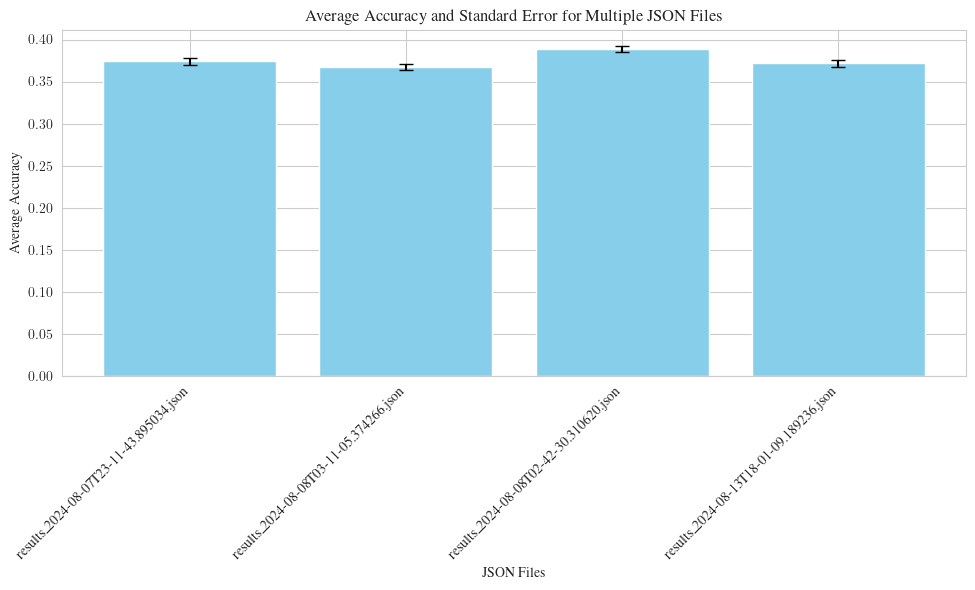

In [53]:
import json
import matplotlib.pyplot as plt
import numpy as np
import glob

# Define the pattern for the JSON files
pattern = "results/lm-eval/70m/to_analyse/*/*/*.json"

# Find all JSON files matching the pattern
file_paths = glob.glob(pattern)

# Initialize lists to store averages and errors
file_labels = []
mean_accuracies = []
sem_accuracies = []

# Loop through each file and compute the mean accuracy and SEM
for file_path in file_paths:
    with open(file_path, 'r') as f:
        json_data = json.load(f)

    # Extract results
    results = json_data["results"]

    # Extract accuracies and their standard errors
    accuracies = []
    accuracies_stderr = []

    for key, value in results.items():
        if "acc,none" in value and "acc_stderr,none" in value:
            accuracies.append(value["acc,none"])
            accuracies_stderr.append(value["acc_stderr,none"])

    # Calculate the mean accuracy and the SEM for the current file
    mean_accuracy = np.mean(accuracies)
    sem_accuracy = np.sqrt(np.sum(np.array(accuracies_stderr) ** 2)) / len(accuracies_stderr)

    # Store the results
    file_labels.append(file_path.split('/')[-1])  # Use the file name as the label
    mean_accuracies.append(mean_accuracy)
    sem_accuracies.append(sem_accuracy)

# Plotting all averages with SEM on the same plot
plt.figure(figsize=(10, 6))
plt.bar(file_labels, mean_accuracies, yerr=sem_accuracies, capsize=5, color='skyblue')
plt.xlabel('JSON Files')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy and Standard Error for Multiple JSON Files')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
